<a href="https://colab.research.google.com/github/mlvlab/DFC609-2022S/blob/master/backtest_BB(180%2C2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 새롭게 업로드된 데이터 로드
file_path_1m = '/content/drive/MyDrive/BTCUSDT_1m_data_0201_0228.csv'
file_path_4h = '/content/drive/MyDrive/BTCUSDT_4h_data_0201_0228.csv'

# 1분봉 데이터 불러오기 및 정리
df_1m = pd.read_csv(file_path_1m)
df_1m['timestamp'] = pd.to_datetime(df_1m['timestamp'])
df_1m.set_index('timestamp', inplace=True)

# 4시간봉 데이터 불러오기 및 정리
df_4h = pd.read_csv(file_path_4h)
df_4h['timestamp'] = pd.to_datetime(df_4h['timestamp'])
df_4h.set_index('timestamp', inplace=True)

# 1분봉 볼린저 밴드 계산 (180, 2)
def calculate_1m_bollinger_bands(df, period=180, std_dev=2):
    df["ma"] = df["close"].rolling(period).mean()
    df["std"] = df["close"].rolling(period).std()
    df["bb_upper"] = df["ma"] + (df["std"] * std_dev)
    df["bb_upper_1.5"] = df["ma"] + (df["std"] * 1.5)
    df["bb_lower"] = df["ma"] - (df["std"] * std_dev)
    df["bb_lower_1.5"] = df["ma"] - (df["std"] * 1.5)
    df.dropna(inplace=True)
    return df

# 볼린저 밴드 계산
df_1m = calculate_1m_bollinger_bands(df_1m)

# ATR(14) 계산
df_1m['tr1'] = abs(df_1m['high'] - df_1m['low'])
df_1m['tr2'] = abs(df_1m['high'] - df_1m['close'].shift(1))
df_1m['tr3'] = abs(df_1m['low'] - df_1m['close'].shift(1))
df_1m['tr'] = df_1m[['tr1', 'tr2', 'tr3']].max(axis=1)
df_1m['atr'] = df_1m['tr'].rolling(14).mean()

# 1분봉 진입 시그널 생성 (4시간봉 필터 없이 롱/숏 모두 허용)
def generate_signals_without_4h_filter(df):
    long_entry_signals = np.zeros(len(df), dtype=bool)
    short_entry_signals = np.zeros(len(df), dtype=bool)

    for i in range(1, len(df)):
        prev_close = df["close"].iloc[i - 1]
        prev_open = df["open"].iloc[i - 1]
        prev_bb_up = df["bb_upper"].iloc[i - 1]  # 1분봉 기준 볼린저 밴드 상단
        prev_bb_lo = df["bb_lower"].iloc[i - 1]  # 1분봉 기준 볼린저 밴드 하단

        # 1분봉 기준 숏 진입 조건 (BB 상단 돌파 & 강한 돌파)
        short_signal = (prev_close > prev_bb_up) and ((prev_close - prev_bb_up) > (prev_bb_up - prev_open))

        # 1분봉 기준 롱 진입 조건 (BB 하단 돌파 & 강한 돌파)
        long_signal = (prev_close < prev_bb_lo) and ((prev_bb_lo - prev_close) > (prev_open - prev_bb_lo))

        long_entry_signals[i] = long_signal
        short_entry_signals[i] = short_signal

    df["long_entry_signal"] = long_entry_signals
    df["short_entry_signal"] = short_entry_signals

    return df

# 새로운 진입 시그널 생성 (4시간봉 조건 없이)
df_final_no_4h_filter = generate_signals_without_4h_filter(df_1m)

# 슬리피지 적용 함수
def calculate_slippage(price, side):
    slip_rate = 0.0008  # 0.08%
    return price * (1 + slip_rate) if side == "buy" else price * (1 - slip_rate)

# 4시간봉 필터를 제거한 백테스트 실행 (ATR 기반 피라미딩 적용) + 매매 내역 저장
def backtest_with_trade_logs(df, atr_multiplier=2):
    pos = 0
    entry_prices = []
    max_pyramids = 3
    pyramid_count = 0
    trade_result = 100  # 초기 자산 100
    pnl_list = []
    trade_count = 0
    asset_values = []
    timestamps = []
    trade_logs = []  # 매매 내역 저장

    for i in range(10, len(df)):
        current_open = df["open"].iloc[i]
        current_close = df["close"].iloc[i]
        bb_upper = df["bb_upper"].iloc[i]  # 1분봉 기준 볼린저 밴드 상단
        bb_upper_1_5 = df["bb_upper_1.5"].iloc[i]
        bb_lower = df["bb_lower"].iloc[i]  # 1분봉 기준 볼린저 밴드 하단
        bb_lower_1_5 = df["bb_lower_1.5"].iloc[i]
        atr = df["atr"].iloc[i]  # 사전 계산된 ATR 사용
        pyramid_threshold = atr * atr_multiplier  # ATR 기반 피라미딩 조건

        timestamps.append(df.index[i])
        asset_values.append(trade_result)

        if pos == 0:
            if df["long_entry_signal"].iloc[i]:
                pos = 1
                entry_price = calculate_slippage(current_open, "buy")
                entry_prices.append(entry_price)
                pyramid_count = 1
                trade_logs.append({"Timestamp": df.index[i], "Stage": "Initial Entry", "Position": "Long", "Entry Price": entry_price})

            elif df["short_entry_signal"].iloc[i]:
                pos = -1
                entry_price = calculate_slippage(current_open, "sell")
                entry_prices.append(entry_price)
                pyramid_count = 1
                trade_logs.append({"Timestamp": df.index[i], "Stage": "Initial Entry", "Position": "Short", "Entry Price": entry_price})

        elif pos == 1:
            avg_entry_price = np.mean(entry_prices)
            if df["long_entry_signal"].iloc[i] and pyramid_count < max_pyramids and avg_entry_price/current_close-1 >= 0.03:
                entry_price = calculate_slippage(current_open, "buy")
                entry_prices.append(entry_price)
                pyramid_count += 1
                trade_logs.append({"Timestamp": df.index[i], "Stage": f"Pyramiding {pyramid_count}", "Position": "Long", "Entry Price": entry_price})

            if current_close >= bb_upper_1_5:
                exit_price = calculate_slippage(df["open"].iloc[i+1], "sell")
                trade_result *= (1 + (exit_price / np.mean(entry_prices) - 1))
                pnl = exit_price - np.mean(entry_prices)
                pnl_list.append(pnl)
                trade_count += 1
                trade_logs.append({"Timestamp": df.index[i], "Stage": "Exit Position", "Position": "Long", "Exit Price": exit_price, "PnL": pnl})
                pos, pyramid_count, entry_prices = 0, 0, []

        elif pos == -1:
            avg_entry_price = np.mean(entry_prices)
            if df["short_entry_signal"].iloc[i] and pyramid_count < max_pyramids and current_close/avg_entry_price-1 >= 0.03:
                entry_price = calculate_slippage(current_open, "sell")
                entry_prices.append(entry_price)
                pyramid_count += 1
                trade_logs.append({"Timestamp": df.index[i], "Stage": f"Pyramiding {pyramid_count}", "Position": "Short", "Entry Price": entry_price})

            if current_close <= bb_lower_1_5:
                exit_price = calculate_slippage(df["open"].iloc[i+1], "buy")
                trade_result *= (1 + (np.mean(entry_prices) / exit_price - 1))
                pnl = np.mean(entry_prices) - exit_price
                pnl_list.append(pnl)
                trade_count += 1
                trade_logs.append({"Timestamp": df.index[i], "Stage": "Exit Position", "Position": "Short", "Exit Price": exit_price, "PnL": pnl})
                pos, pyramid_count, entry_prices = 0, 0, []

    df_trade_logs = pd.DataFrame(trade_logs)
    return timestamps, asset_values, pnl_list, trade_count, trade_result, df_trade_logs

timestamps, trade_count, pnl_list, trade_count, trade_result, df_trade_logs = backtest_with_trade_logs(df_final_no_4h_filter)


In [11]:


trades = []  # 최종적으로 저장할 트레이드 리스트
current_trade = []  # 현재 진행 중인 트레이드
current_position = None  # 현재 포지션 추적

def calculate_trade_return(trade):
    """ 트레이드 단위의 마지막 진입 가격과 수익률을 계산 """
    if not trade:
        return None

    last_entry_price = trade[-2]['Entry Price'] if len(trade) > 1 and pd.notna(trade[-2]['Entry Price']) else None
    exit_price = trade[-1]['Exit Price']
    position = trade[0]['Position']

    if last_entry_price and exit_price:
        if position == 'Long':
            trade_return = (exit_price / last_entry_price) - 1
        elif position == 'Short':
            trade_return = (last_entry_price / exit_price) - 1
        else:
            trade_return = None
    else:
        trade_return = None

    return {
        "Position": position,
        "Last Entry Price": last_entry_price,
        "Exit Price": exit_price,
        "Return": trade_return
    }

# 트레이드 단위로 그룹화
for _, row in df_trade_logs.iterrows():
    if row['Stage'] == 'Initial Entry':  # 새로운 트레이드 시작
        if current_trade:
            trades.append(calculate_trade_return(current_trade))
        current_trade = [row]
        current_position = row['Position']
    elif row['Stage'].startswith('Pyramiding'):  # 피라미딩 추가
        if current_trade and current_position == row['Position']:
            current_trade.append(row)
    elif row['Stage'] == 'Exit Position':  # 트레이드 종료
        if current_trade and current_position == row['Position']:
            current_trade.append(row)
            trades.append(calculate_trade_return(current_trade))
            current_trade = []  # 초기화
            current_position = None

# 데이터프레임 변환 및 출력
df_trades = pd.DataFrame(trades)

# Calculate cumulative returns
df_trades['Cumulative Return'] = (1 + df_trades['Return']).cumprod() - 1

df_trades


,Position,Last Entry Price,Exit Price,Return,Cumulative Return
0,Long,104197.99176,102246.13760,-0.018732,-0.018732
1,Short,102511.22536,102409.56216,0.000993,-0.017758
2,Long,102352.11624,102432.78816,0.000788,-0.016984
3,Short,102520.01832,102281.76000,0.002329,-0.014694
4,Long,102221.91216,101912.20496,-0.003030,-0.017679
...,...,...,...,...,...
250,Short,85216.37232,85988.83608,-0.008983,1.023240
251,Short,86701.98288,86270.06088,0.005007,1.033369
252,Long,86092.11864,86390.83200,0.003470,1.040425
253,Short,86701.98288,86300.88552,0.004648,1.049908


In [12]:
# prompt: df_trades의 승률을 보고싶어

# Winning rate calculation
winning_trades = df_trades[df_trades['Return'] > 0]
winning_rate = len(winning_trades) / len(df_trades) if len(df_trades) > 0 else 0

print(f"Winning Rate: {winning_rate:.2%}")


Winning Rate: 75.29%


<ipython-input-8-e5a80a6c866d>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_trades['Cumulative Return'].fillna(method='ffill', inplace=True)
<ipython-input-8-e5a80a6c866d>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_trades['Cumulative Return'].fillna(method='ffill', inplace=True)


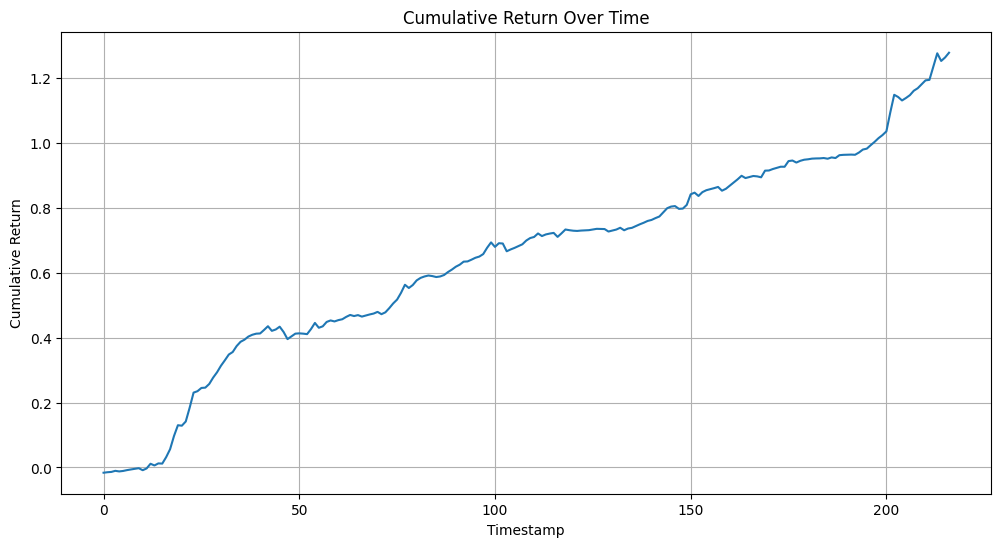

In [8]:
# prompt: 누적수익이 업데이트 되기 전에는 직전값으로 하고, 시계열 추이를 보여줘

import matplotlib.pyplot as plt

# 누적 수익률 계산 (이전 값으로 채우기)
df_trades['Cumulative Return'].fillna(method='ffill', inplace=True)

# 시계열 추이 그래프
plt.figure(figsize=(12, 6))
plt.plot(df_trades['Cumulative Return'])
plt.xlabel('Timestamp')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return Over Time')
plt.grid(True)
plt.show()
